## Introduction to Unfolding with RooUnfold 1: Unfolding Methods

[See also in pyROOT](RooUnfold_01-Methods_PY.ipynb)

In [1]:
!git clone https://gitlab.cern.ch/RooUnfold/RooUnfold.git

fatal: destination path 'RooUnfold' already exists and is not an empty directory.


In [2]:
!cd RooUnfold && make

Use ROOT 6.16/00 for linuxx8664gcc from /cvmfs/sft.cern.ch/lcg/releases/ROOT/6.16.00-975ad/x86_64-centos7-gcc7-opt
make: Nothing to be done for `default'.


In [3]:
gSystem->Load("RooUnfold/libRooUnfold")

(int) 0


### Mathematical Problem

A histogram of some distribution $y$ has $M$ bins. $\widehat \mu$ represents the ezpection value of the number of entries in bin $i$ of the histogram. So it progresses for the *true* histogram; $\mu_\mathrm{Tot}=\sum_i\mu_i$ and $p(y|i)=p_i=\mu_i/\mu_\mathrm{Tot}$ The goal of this problem is not to estimate the parameters $\theta$ that parametrise $f(y;\theta)$ but instead the $\mu_i$ parameters for each bin $\overline{\mu}=(\mu_1,...,\mu_M)$. This is not trivial because of fluctuations caused by the act of the measurement itself. Each observation is characterised by a unknown underlying value which is our function $y$ which we are interested in and a measured value $x$ obtained by the experiment.

$$
f(x)_\mathrm{meas}=\int R(x|y)f_\mathrm{true}(y)dy
$$

Where $R(x|y)$ is the response function if $x$ and $y$ are the pdfs represented by histograms. This can be done in RooUnfold as:

In [4]:
RooUnfoldResponse response (40, -10.0, 10.0);

In which the first term is the number of bins and the range over which you which this function to be valid over however the crux of the function needs a true histogram and a measured histogram to produce a response which can be drawn as a two dimensional histogram. Before we make one let's see how they're used!

**note** this definition of the unfolding Response is a square matrix from `-10` to `10` however the solution to such a system can be under constrained. Consider changing the range to have more measured bins than truth:

``	RooUnfoldResponse(Int_t nm, Double_t mlo, Double_t mhi, Int_t nt, Double_t tlo, Double_t thi)``

### Aproximating Smearing

first we make some function that smears some distribution and removes certain events to mimic the measurement efficiency.

In [5]:
const Double_t cutdummy= -99999.0;

In [6]:
%%cpp -d
Double_t smear (Double_t xt){
  Double_t xeff= 0.3 + (1.0-0.3)/20*(xt+10.0);  // efficiency
  Double_t x= gRandom->Rndm();
  if (x>xeff) return cutdummy;
  Double_t xsmear= gRandom->Gaus(-2.5,0.2);     // bias and smear
  return xt+xsmear;
}

In [7]:
auto *f0 = new TH1F("f0","f0",40,-10,10);
auto *g0 = new TH1F("g0","g0",40,-10,10);

Here we train our mapping response with a Breit-Wigner, mean 0.3 and width 2.5.     

In [8]:
for (Int_t i= 0; i<100000; i++) {
    Double_t xt= gRandom->BreitWigner (0.3, 2.5);
    f0->Fill(xt);
    Double_t x= smear (xt);
    if (x!=cutdummy){
      g0->Fill(x);
      response.Fill (x, xt);
    }
    else{
        response.Miss (xt);
    }
  }

The response function is populated through the use of the `Fill` and `Miss` functions. One mapping the event to a response function the other used to calculate the efficiency of the system accross the space of the true system. 

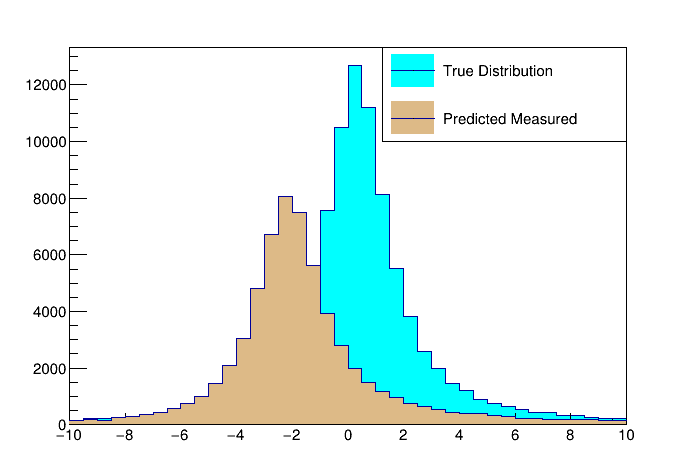

Info in <TCanvas::Print>: png file true-response.png has been created


In [9]:
auto* c = new TCanvas();
f0->SetStats(0);
f0->SetTitle("");
f0->SetFillColor(7);
f0->Draw();
g0->SetFillColor(42);
g0->Draw("same");
auto* leg = new TLegend(.55,0.7,.9,.9);
leg->AddEntry(f0,"True Distribution");
leg->AddEntry(g0,"Predicted Measured");
leg->Draw();
c->Draw();
c->SaveAs("true-response.png");

#### Understanding this plot

Here we generate two distributions. One *true* distribution we call $f0$ is a Breit-Wigner. $g0$ however is smeared according to some detector effect. In this case some random events are dropped to mimic the detector efficiency and the rest are shifted by some gaussian resolution.

This step is the crux of the unfolding problem. In this case, for every event, we know the relationship between the true and expected measured values and from this we begin to approximate $R(x|y)$ 

In later steps we use this response function to recover the *true* distribution given some measured values. This is unfolding.

### Visualising the Response Matrix

The choice of which solution should be used for unfolding may depend on the nature of this response function. Typically in particle physics the response $R(x|y)$ concerns the migration of events from one bin to another with some probability in a Response Matrix. In this case the choice of unfolding method depends on the linearity of the response matrix with larger off-diagonal contributions requiring stronger regularisation.

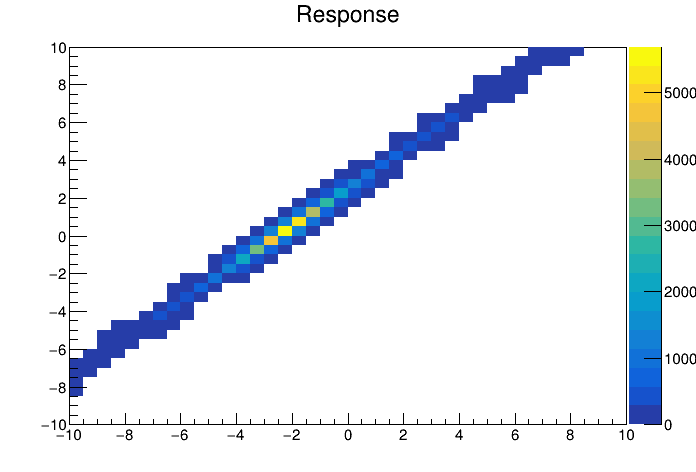

Info in <TCanvas::Print>: png file response.png has been created


In [10]:
auto* R = response.HresponseNoOverflow();
auto* c1 = new TCanvas();
R->SetStats(0);
R->Draw("colz");
c1->Draw();
c1->SaveAs("response.png");

### Working with Histograms

At this point we should also change from our $f_\mathrm{meas}(x)$ to a notation more suitable to histograms. 

$$
f(x)_\mathrm{meas}=\int R(x|y)f_\mathrm{true}(y)dy
$$

becomes

$$
\nu_i=\sum_{j=1}^M R_{ij}\mu_j,\ \ \ \ \ i= 1,...,N
$$

Where $\mu$ is once again the expectation values for the histogram of $y$ and $\nu$ is the expected number of events in the bins of the observed variable $x$. 
**note**. True data will be an actual event count in each bin and therefore integer values whereas $\nu$ is typically non-integer values. 

We can understand the response matrix as the conditional probability. By summing over the observed data we get the efficiency $\epsilon_j$ for each bin of the true histogram.

We now have several ingreedients; $\nu,\mu$ and $R$. Since the data is a collection of integers $\mathbf{n}$ we can express the above equation as not only the expectation value per bin given the data but also to include the expected number of background events in that bin $\beta_i$. 

$$
E[\mathbf{n}]=\nu=R\mu+\beta
$$

<center> <h3> Interlude: Don't unfold if you can help it. </h3></center>

Unfolding allows for the preservation of the results of the experiment as it preserves a snapshot of the experimental response within its result. However this information is rarely actually preserved and therefore when errors are inevitably made, the mistakes might forever make the results of the experiment un-usable unless both the data and the response matrix are preserved. 

Anyway, moving on...

#### Unfolding? What's that?
By unfolding we construct estimators  $\widehat{\mu}$ for the bins of $y$ This is useful to directly compared with the results of other experiments as well as with theoretical predictions.


If our goal is generally $\mu$ then we need to invert our response matrix. 
$$
\boldsymbol{\mu}= R^{-1}(\boldsymbol{\nu}-\beta)
$$
We can assume the data is independent (individual events) and therefore each bin can be assumed to follow a poisson distribution.

$$
P(n_i;\nu_i)=\frac{\nu_u^{n_i}}{n_i\!}\exp^{-\nu_i}
$$

The maximum likelihood estimators for $\nu$ are $\mathbf{n}$ and thus can be taken as estimators for $\mu$,

$$
\boldsymbol{\widehat{\mu}}=R^{-1}(\mathbf{n}-\beta)
$$

In a perfect (exact) world all of the elements of the response matrix should be on the diagonal as large, off-diagonal elements indicate that the bin size is too small compared to the measurement resolution, then the estimates of $\ \boldsymbol{\widehat{\mu}}$ will have prohibatively large variances and will have strong negative correlations between neighbouring bins. It can be [proved](http://www.ippp.dur.ac.uk/Workshops/02/statistics/proceedings/cowan.ps) that for independent poisson variables ML estimators in this case are unbiased. By calculating the minimum variance bound in this (unbiased) case we can assume that any estimators that we can construct that have a smaller variance will be biased in some way. This method can be understood as mittigating the effects of a large statistical error in favour of a smaller systematic error.

### Matrix Inversion

Given that we now have the response matrix and the histogram representaton of the input function we can begin to explore the reasons that unfolding isn't so straightforward.

After training the response on a Breit-Wigner we can now unfold any measured distribution (provided it is defined in the range of the orignial function). Let us first consider a gaussian distribution.

In [11]:
TH1D* hTrue= new TH1D ("true", "Test Truth",    40, -10.0, 10.0);
TH1D* hMeas= new TH1D ("meas", "Test Measured", 40, -10.0, 10.0);
// Test with a Gaussian, mean 0 and width 2.
for (Int_t i=0; i<10000; i++) {
    Double_t xt= gRandom->Gaus (0.0, 2.0), x= smear (xt);
    hTrue->Fill(xt);
    if (x!=cutdummy) hMeas->Fill(x);
}

We already have the response matrix so we can call the inversion on the measured distribution. 

In [12]:
RooUnfoldInvert   unfold (&response, hMeas);
auto* hReco = unfold.Hreco();

The "bad condition" warning is likely a reference that the matrix is not positive definite.

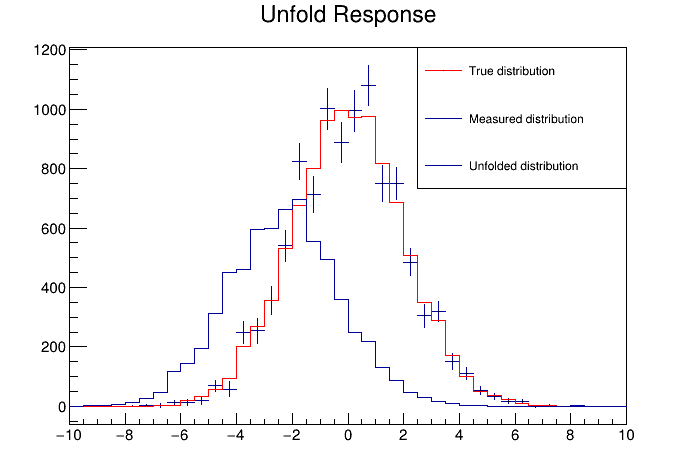

In [13]:
auto* c2 = new TCanvas();
hReco->SetStats(0);
hTrue->SetLineColor(2);
hReco->Draw();
hTrue->Draw("same");
hMeas->Draw("same");
auto* leg2 = new TLegend(0.6, 0.6, 0.9, 0.9);
leg2->AddEntry(hTrue, "True distribution","pl");
leg2->AddEntry(hMeas, "Measured distribution", "pl");
leg2->AddEntry(hMeas, "Unfolded distribution");
leg2->Draw();
c2->Draw();

Nominally we can see that this solution works quite nicely. The reconstructed distribution has some unexpected bumps and dips but generally follows the distribution we want. But what happens if we take a less well behaved problem?

### Double Peaks and the Riemann–Lebesgue lemma

Nominally the problem with such naive unfolding should be obvious. What happens when we move our truth distribution through some detector simulation is essentially some degree of smearing. Some randomness and inefficiencies lead to loss of information. What happens when we flip that smearing function around? we have a blurry image that we are told to artificially add spikes and peaks to. The Riemann-Lebesgue lemma discusses this behaviour. Any arbritrarily small fluctuations in the measured data can lead to equally arbitarily huge variations in the predicted distribution.

To visualise this we choose a new response. This time based on a double peak structure. 

In [14]:
RooUnfoldResponse double_response (40, -10.0, 10.0);
auto *f1 = new TH1F("f1","f1",40,-10,10);
auto *g1 = new TH1F("g1","g1",40,-10,10);
for (Int_t i= 0; i<5000; i++) {
    Double_t xt1= gRandom->Gaus (2, 1.5);
    f1->Fill(xt1);
    Double_t x1= gRandom->Gaus (xt1, 1.);
    if (x1!=cutdummy){
      g1->Fill(x1);
      double_response.Fill (x1, xt1);
    }
    else{
        double_response.Miss (xt1);
    }
    Double_t xt2= gRandom->Gaus (-2, 1.5);
    f1->Fill(xt2);
    Double_t x2= gRandom->Gaus (xt2, 1.);
    if (x2!=cutdummy){
      g1->Fill(x2);
      double_response.Fill (x2, xt2);
    }
    else{
        double_response.Miss (xt2);
    }
}

Here we make the response function exactly as before only now we make two gaussian peaks one at `-2` and one at `2` this time however the smearing function doesn't smear in any direction just by the gaussian noise itself. 

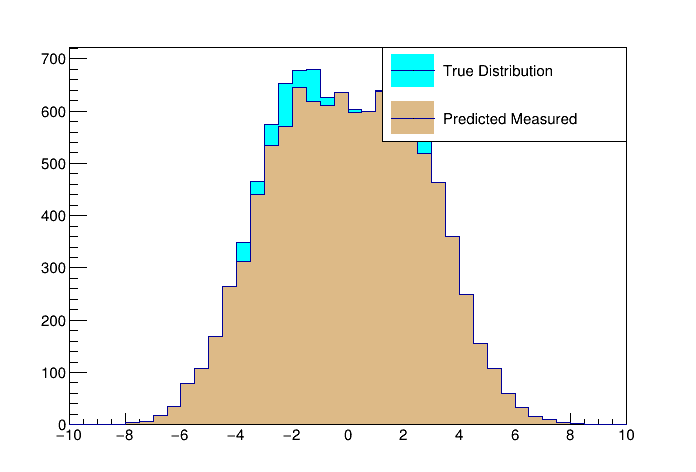

Info in <TCanvas::Print>: png file double-peak-response.png has been created


In [15]:
auto* c3 = new TCanvas();
f1->SetStats(0);
f1->SetTitle("");
f1->SetFillColor(7);
f1->Draw();
g1->SetFillColor(42);
g1->Draw("same");
auto* leg3 = new TLegend(.55,0.7,.9,.9);
leg3->AddEntry(f1,"True Distribution");
leg3->AddEntry(g1,"Predicted Measured");
leg3->Draw();
c3->Draw();
c3->SaveAs("double-peak-response.png");

In physics processes such a distribution is not so bizzare to expect. However it illustrates our problem. When we now try to invert such a response matrix everything goes wrong...

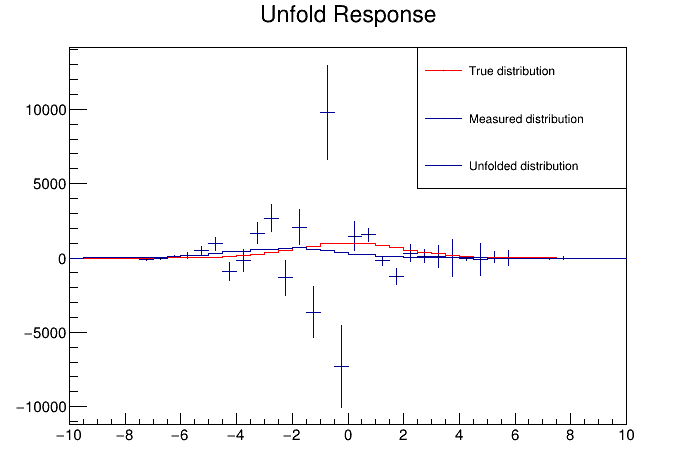

In [16]:
RooUnfoldInvert   unfold_double (&double_response, hMeas);
auto* hReco2 = unfold_double.Hreco();
auto* c4 = new TCanvas();
hReco2->SetStats(0);
hTrue->SetLineColor(2);
hReco2->Draw();
hTrue->Draw("same");
hMeas->Draw("same");
auto* leg4 = new TLegend(0.6, 0.6, 0.9, 0.9);
leg4->AddEntry(hTrue, "True distribution","pl");
leg4->AddEntry(hMeas, "Measured distribution", "pl");
leg4->AddEntry(hReco2, "Unfolded distribution");
leg4->Draw();
c4->Draw();

### Corrections from simulation

In high energy physics a simple method to construct estimators using simulations in order to produced estimators with smaller variances. This takes the form of a correction factor:

$$
\widehat{\mu}_i=\frac{\mu_i^\mathrm{MC}}{\nu_i^\mathrm{MC}}(n_i-\beta_i)
$$

Here the superscript $^\mathrm{MC}$ denotes values obtained from Monte Carlo simulation. Usually this is only done for the signal process since the background is subtracted separately. 

The covariance matrix for the process is given as:
$$
U_{ij}=\mathbf{cov}[\widehat{\mu}_i,\widehat{\mu}_j]=C_i^2\mathbf{cov}[n_i,n_j]
$$

If the correction factors are not too large (order of unity) the variances of the estimators do not become much larger than those provided by the poisson statistics of the data. These estimators are biased $b_i=E[\widehat{\mu}_i]-\mu_i\neq0$ but this bias can be calculated as:
$$
b_i = \left(\frac{\mu_i^\mathrm{MC}}{\nu_i^\mathrm{MC}}-\frac{\mu_i}{(\nu_i-\beta_i)}\right)(\nu_i-\beta_i)
$$

Since this bias is related to the correctness of the model the bias tends to pull the estimators towards the predictions of the MC that we used for making the correction factors. In general this is better estimated by directly comparing the data and the models predicted $\nu$ since use of this method requires including an estimate of the bias as a systematic uncertainty of the measurement. 

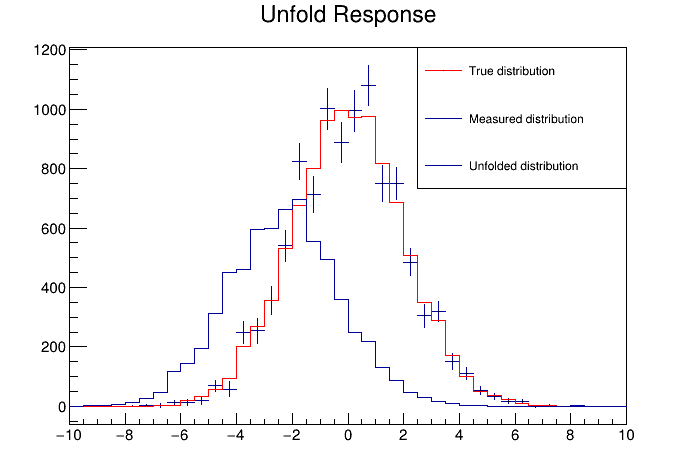

In [17]:
RooUnfoldInvert   unfold_bin (&response, hMeas);
auto* hReco_bin = unfold_bin.Hreco();
auto* c5 = new TCanvas();
hReco_bin->SetStats(0);
hTrue->SetLineColor(2);
hReco_bin->Draw();
hTrue->Draw("same");
hMeas->Draw("same");
auto* leg5 = new TLegend(0.6, 0.6, 0.9, 0.9);
leg5->AddEntry(hTrue, "True distribution","pl");
leg5->AddEntry(hMeas, "Measured distribution", "pl");
leg5->AddEntry(hReco_bin, "Unfolded distribution");
leg5->Draw();
c5->Draw();

### Bayesian Unfolding

this is an iterative method introduced to particle physics by [D'Agostini](http://inspirehep.net/record/374574?ln=en) based on the elements of Bayesian statistics. In other fields this is known as Richardson-Lucy deconvolution. An initial set of probabilities are given as $p_i=1/M$ for bins of equal size and these are used to provide the initial estimators. 
$$
\boldsymbol{\widehat{\mu}}_0=n_{tot}\mathbf{p}_0
$$

These are updated using bayes theorem to write the conditional probability that the event originate in bin $i$ given that it was observed in bin $j$ using the response matrix $R$ and the prior probabilities $\mathbf{p}$:

$$
\boldsymbol{\widehat{\mu}}_i=\frac{1}{\epsilon_i}\sum_{j=1}^N P(\mathrm{\ true\ value\ in\ bin\ }i\ |\ \mathrm{found\ in\ bin\ }j\ )\ n_j
$$

$$
=\frac{1}{\epsilon_i}\sum_{j=1}^N\left(\frac{R_{ij}p_i}{\sum_kR_{jk}p_k}\right)
$$

These updated estimators are compared to those of the previous iteration by using a goodness of fit test such as the $\chi^2$ test and then repeated if necesarry. 

<center> <h3> Interlude: Not actually Bayesian. </h3></center>

The procedure uses Bayes’ theorem in an intermediate step however, calling it a Bayesian method implies that the estimators summarize in some way a joint posterior pdf for $\mu$, normaly that $p(\boldsymbol{\mu}|\mathbf{n})$ is related to the likelihood and the prior probability. Since this is not the case the *iterative* method is more descriptive... but less commonly used.  

anyway... moving on...

### Incomplete Regularisation
This method includes a third term in the `unfold` constructor - the regularisation strength. The naive matrix inversion can be understood as the maximum likelihood estimator for the response matrix. As prieviously discussed, though unbiased, this solution suffers from catestrophically large variances in the solution. This iterative approch addresses this issue by interupting the maximum likelihood proceedure before it converges to its true maximum. Hereby trading a small bias for substantially smaller variances. 

The number of iterations can be considered akin to a tool called regularisation whereby the effects of extreme fluctuations in data are mitigated. The stronger the regularisation the more bias introduced but the smaller the effects of the rieman-lebesgue fluctuations.

The default number of iterations in the `RooUnfoldBayes` algorithm is 4.

In [18]:
RooUnfoldBayes   unfold_bayes (&response, hMeas, 4);
auto* hReco_bayes = unfold_bayes.Hreco();

Now unfolding...
Iteration : 0
Chi^2 of change 970.321
Iteration : 1
Chi^2 of change 7.84678
Iteration : 2
Chi^2 of change 1.56566
Iteration : 3
Chi^2 of change 0.843821
Calculating covariances due to number of measured events


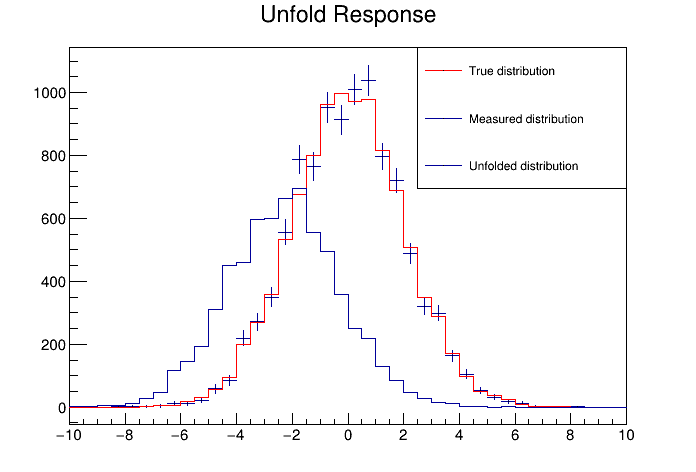

In [19]:
auto* c6 = new TCanvas();
hReco_bayes->SetStats(0);
hTrue->SetLineColor(2);
hReco_bayes->Draw();
hTrue->Draw("same");
hMeas->Draw("same");
auto* leg6 = new TLegend(0.6, 0.6, 0.9, 0.9);
leg6->AddEntry(hTrue, "True distribution","pl");
leg6->AddEntry(hMeas, "Measured distribution", "pl");
leg6->AddEntry(hReco_bayes, "Unfolded distribution");
leg6->Draw();
c6->Draw();

In the following animation the effect of the regularisation term can be seen. Already at only 2 iterations does the function give a good approximation of the target. Further iterations only serve to increase the size of the error bars on the reconstructed function. 

![wiggles!](./unfold.gif "if it doesn't look like this you're doing it wrong")

### Regularised Unfolding

In the prievious example the number of iterations can be understood as a form of regularisation in that it prevents the fit to the predicted values of $\mu$ from reaching the optimum solution.

The iterative approach prieviously and this damped approach act upon the least squares or likelihood based estimation for the unfolded specrum, either by adding a system of lagrange mulipliers to the minimisation function (in the case of regularised unfolding) or controling the minimisation process itself (as in the iterative Richardson-Lucy approach).

The damped least squares solution, also known as tikonov regression or L2 regularisation or Ridge regression constructs estimators by minimising the likelihood together with some measure of the smoothness of the function. The form of the minimisation now takes the form:
$$
\Phi(\mu)=\ln \mathcal(L)(\mu)+\tau S(\mu)
$$

􏰜Where $S(\mu)$ is the regularization function, which represents the smoothness of the distribution, and 􏰛$\tau$ is the regularization parameter, which can be chosen to correspond to a given in $\Delta\ln\mathcal(L)$

In least squares terms (where the function will be minimised using some internal regularisation function - usually the Paige and Saunders algorithm) this can be given as:

$$\min \begin{Vmatrix} y && -Ax \\ 0 && \tau I \\ \end{Vmatrix}_2^2$$

The regularisation parameter is optimised internally by plotting $log_{10}(\chi^2)$ against $log_{10}(tau)$. The 'kink' in this curve is deemed the optimum $\tau$ value. This process is known as *L-curve optimisation*.

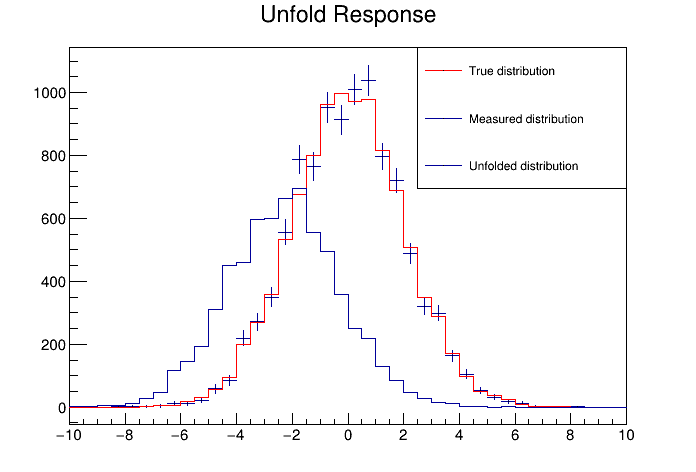

In [20]:
auto* c7 = new TCanvas();
hReco_bayes->SetStats(0);
hTrue->SetLineColor(2);
hReco_bayes->Draw();
hTrue->Draw("same");
hMeas->Draw("same");
auto* leg7 = new TLegend(0.6, 0.6, 0.9, 0.9);
leg7->AddEntry(hTrue, "True distribution","pl");
leg7->AddEntry(hMeas, "Measured distribution", "pl");
leg7->AddEntry(hReco_bayes, "Unfolded distribution");
leg7->Draw();
c7->Draw();

### Regularised Decomposition.

The default shape for the response matrix in RooUnfold is square. Ideally our minimisation problem would like to have more input data than it is required to output. Necessitating a rectangular matrix. Rectangular matrices are non-invertable. Instead the pseudo inverse is found using the singular value decomposition. This proceedure splits the matrix into a series of functional contributions to the matrix with coefficients that decrease in size. Most important information to less. These lower order contributions are exactly those that produce larger Rieman-Lebesgue fluctuations in the functional analysis of the problem. By only taking the leading terms in the SVD when inverting the response matrix we impose a degree of entropy on the system and minimise the effect of troublesome fluctuations.

The `tSVD` proceedure does just this. It gives the pseudo inverse of the response matrix only including the first $n$ leading contributions. The default is the number of bins/2. Beyond this we can consider any results statistical fluctuations.

In [21]:
RooUnfoldSvd   unfold_SVD (&response, hMeas);
auto* hReco_svd = unfold_SVD.Hreco();

SVD init 40 x 40 bins, kreg=20


Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 20
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.008766


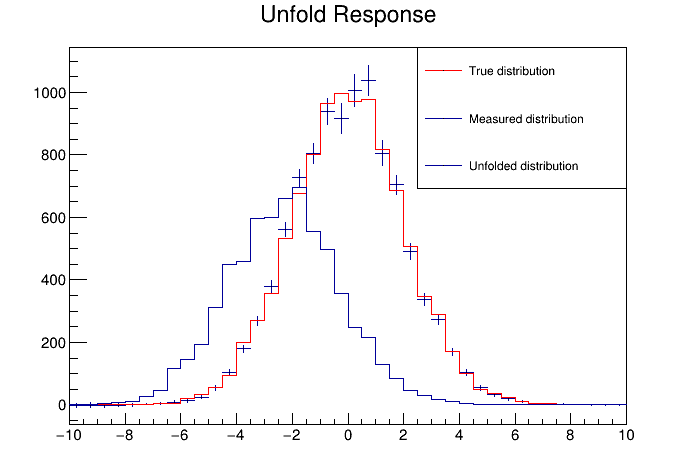

In [22]:
auto* c8= new TCanvas();
hReco_svd->SetStats(0);
hTrue->SetLineColor(2);
hReco_svd->Draw();
hTrue->Draw("same");
hMeas->Draw("same");
auto* leg8 = new TLegend(0.6, 0.6, 0.9, 0.9);
leg8->AddEntry(hTrue, "True distribution","pl");
leg8->AddEntry(hMeas, "Measured distribution", "pl");
leg8->AddEntry(hReco_svd, "Unfolded distribution");
leg8->Draw();
c8->Draw();